In [1]:
import numpy as np
train=np.load('./out/tiny_test.npy')
train_mask=np.load('./out/tiny_test_mask.npy')

train = train.astype('float32')
mini = np.min(train)  # mean for data centering
maxi = np.max(train)  # std for data normalization
train -= mini
train /= (maxi -mini)

train_mask = train_mask.astype('float32')
mask_max=np.max(train_mask)
train_mask/=mask_max
# scale masks to [0, 1]
print(train.shape, train_mask.shape)
print(np.min(train), np.max(train), np.min(train_mask),np.max(train_mask))


(100, 96, 96, 1) (100, 96, 96, 1)
0.0 1.0 0.0 1.0


In [3]:
import time
import tensorflow.compat.v2 as tf
from tensorflow.keras.models import Model , Sequential
from tensorflow.keras.layers import * 
import tensorflow


In [4]:
from tensorflow.python.client import device_lib
def check_tensor_core_gpu_present():
    local_device_protos = device_lib.list_local_devices()
    for line in local_device_protos:
        
        if "compute capability" in str(line):
            return True

print("tensorflow version is ", tf.__version__)

print("is Nvidia gpu present = ", check_tensor_core_gpu_present())


tensorflow version is  2.0.0
is Nvidia gpu present =  True


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization , Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision

smooth = 1.

smooth = 1.


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### customized unet loss function in order to ensure sucess and fast training 
def combined_dice_binary_loss(y_true,y_pred):
    def dice_loss(y_true,y_pred):
        numerator= 2 * tf.reduce_sum( y_true * y_pred, axis=(1,2,3))
        denominator = tf.reduce_sum(y_true +y_pred, axis=(1,2,3))
        return tf.reshape(1-numerator/denominator, (-1,1,1))
    return binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)
def get_unet( mix_precision_enabled=False , opt=Adam(lr=1e-5)):
    
    inputs = Input((96, 96, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    if mix_precision_enabled:
        policy = mixed_precision.Policy('mixed_float16')
        mixed_precision.set_policy(policy)
        #opt=tensorflow.compat.v2.train.experimental.enable_mixed_precision_graph_rewrite(opt)
    model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[dice_coef])

    return model

model=get_unet()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 96, 96, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 96, 96, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 48, 48, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import time

# uncomment to retrain the model
EPOCHS = 201
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=99)
checkpoint_path = "tf_checkpoint/"

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    monitor='val_loss',
    save_best_only=True)

start=time.time()
model_history = model.fit(train, train_mask, batch_size=12, epochs=EPOCHS, verbose=1, shuffle=True,validation_data=(train,train_mask),
          callbacks=[cp_callback,early_stopping_callback])
end=time.time()

Train on 100 samples, validate on 100 samples
Epoch 1/201
 84/100 [========================>.....] - ETA: 0s - loss: -0.0562 - dice_coef: 0.0562WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: tf_checkpoint/assets
100/100 [==============================] - 7s 74ms/sample - loss: -0.0555 - dice_coef: 0.0561 - val_loss: -0.0556 - val_dice_coef: 0.0558
Epoch 2/201
100/100 [==============================] - 5s 53ms/sample - loss: -0.0556 - dice_coef: 0.0554 - val_loss: -0.0556 - val_dice_coef: 0.0558
Epoch 3/201
100/100 [==============================] - 5s 52ms/sample - loss: -0.0556 - dice_coef: 0.0550 - val_loss: -0.0557 - val_dice_coef: 0.0559


In [6]:
train=train.astype('float32')
train_mask=train_mask.astype('float32')

In [ ]:
tf.keras.backend.clear_session()
time.sleep(10)

In [8]:

mp_model=get_unet(mix_precision_enabled=True, opt=Adam(lr=1e-5))
mp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 96, 96, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 96, 96, 32)   9248        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 48, 48, 32)   0           conv2d_20[0][0]                  
____________________________________________________________________________________________

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import time

# uncomment to retrain the model
EPOCHS = 201

start=time.time()
mp_model_history = mp_model.fit(train, train_mask, batch_size=12, epochs=EPOCHS, verbose=1, shuffle=True,validation_data=(train,train_mask))
end=time.time()
print("mixed precision enabled training time", round((end-start)/60,4))

Train on 100 samples, validate on 100 samples
Epoch 1/201
100/100 [==============================] - 5s 53ms/sample - loss: -0.0550 - dice_coef: 0.0549 - val_loss: -0.0551 - val_dice_coef: 0.0552
Epoch 2/201
100/100 [==============================] - 0s 2ms/sample - loss: -0.0551 - dice_coef: 0.0547 - val_loss: -0.0552 - val_dice_coef: 0.0553
Epoch 3/201
100/100 [==============================] - 0s 2ms/sample - loss: -0.0552 - dice_coef: 0.0552 - val_loss: -0.0552 - val_dice_coef: 0.0554
Epoch 4/201
100/100 [==============================] - 0s 2ms/sample - loss: -0.0553 - dice_coef: 0.0553 - val_loss: -0.0553 - val_dice_coef: 0.0555
Epoch 5/201
100/100 [==============================] - 0s 2ms/sample - loss: -0.0553 - dice_coef: 0.0559 - val_loss: -0.0554 - val_dice_coef: 0.0555
Epoch 6/201
100/100 [==============================] - 0s 2ms/sample - loss: -0.0554 - dice_coef: 0.0547 - val_loss: -0.0554 - val_dice_coef: 0.0556
Epoch 7/201
100/100 [==============================] - 0s 2

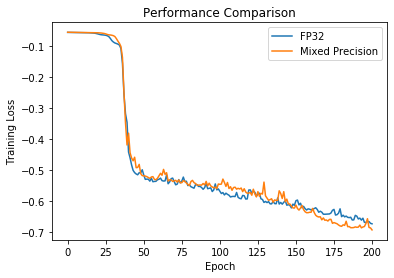

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(model_history.history["loss"], label="FP32")
plt.plot(mp_model_history.history["loss"], label="Mixed Precision")
plt.title("Performance Comparison")
plt.ylabel("Training Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [13]:
!pip install matplotlib

     |████████████████████████████████| 13.1MB 9.3MB/s eta 0:00:01
     |████████████████████████████████| 92kB 13.9MB/s eta 0:00:01
     |████████████████████████████████| 71kB 11.9MB/s eta 0:00:01


In [17]:
start=time.time()
out1=model.predict(train)
end=time.time()
basetime=end-start
print("no mixed precision model prediction took : ", basetime)

start=time.time()
out2=mp_model.predict(train)
end=time.time()
compare_time=end-start
print("with mixed precision model prediction took : ", compare_time)

no mixed precision model prediction took :  0.6345272064208984
with mixed precision model prediction took :  0.3350532054901123


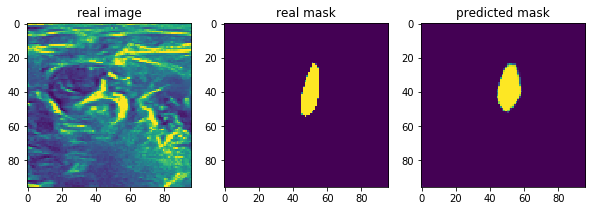

In [18]:
import matplotlib.pyplot as plt
import random
rn=random.randint(0,len(train)-1)
%matplotlib inline
out= mp_model.predict(train[rn].reshape(1,96,96,1))
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1,3,1)
plt.imshow(np.squeeze(train[rn]*96))
plt.title('real image')

fig.add_subplot(1,3,2)
plt.imshow(np.squeeze(train_mask[rn]))
plt.title('real mask')


fig.add_subplot(1,3,3)
plt.imshow(np.squeeze(out))
plt.title('predicted mask')

plt.show()


In [ ]:
!pip install tf-explain

# visualize with tensorboard using tf-explain

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances


In [ ]:
!tensorboard --logdir=logs --host localhost --port 8088

In [ ]:
%%html
<table cellspacing='1'>
<td>  
    <td> <img src="model.JPG" alt="image" style="width: 1500px;"/> </td>
</table>

In [ ]:
%%html
<table cellspacing='1'>
<td>  
    <td> <img src="tensorboard_visualize.JPG" alt="image" style="width: 1500px;"/> </td>
</table>

In [ ]:
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
#notebook.display(port=6006, height=800)

In [ ]:
from tf_explain.callbacks.grad_cam import GradCAMCallback


callbacks = [
    GradCAMCallback(
        validation_data=(train, train_mask),
        layer_name="conv2d_18",
        class_index=1,
        output_dir='./logs',
    )
]

m.fit(train, train_mask, batch_size=2, epochs=2, callbacks=callbacks)

In [ ]:
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

callbacks = [
    ActivationsVisualizationCallback(
        validation_data=(train, train_mask),
        layers_name=["conv2d_16"],
        output_dir='./logs',
    ),
]

m.fit(train, train_mask, batch_size=2, epochs=2, callbacks=callbacks)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import clear_output
import matplotlib.pyplot as plt
from tf_explain.callbacks.activations_visualization import ActivationsVisualizationCallback

from tf_explain.callbacks.gradients import VanillaGradientsCallback
from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
from tf_explain.callbacks.grad_cam import GradCAMCallback
from tf_explain.callbacks.smoothgrad import SmoothGradCallback
from tf_explain.callbacks.integrated_gradients import IntegratedGradientsCallback